# Baseline fraud detection system

This section aims at showing how a simple fraud detection system can be designed in a few steps. We will use the simulated data generated in the previous section. 

We will rely on a supervised learning approach. The topic of supervised learning will be covered in greater detail in later chapters. For this section, it is only sufficient to know that supervised learning allows to find a function that provides the probability for a transaction to be fraudulent. This function is called a *prediction model*, and is found using a procedure called *training*. The training requires a set of examples of genuine and fraudulent transactions, called the *training set*. 

The design of our fraud detection system will consist of three main steps:

1. Defining a training and test sets: The training set will be a subset of transactions that will be used for training the prediction model. The test set will be a subset of transactions that will be used to assess the accuracy of the prediction model.
2. Training a prediction model: This step will consist in using the training set to find a prediction model able to predict whether a transaction is genuine or fraudulent. We will rely for this task on the Python `sklearn` library, which provides easy-to-use functions to train prediction models. 
3. Assessing the accuracy of the prediction model: The accuracy of the prediction model will be assessed using the test set. 

We detail each of these steps in the rest of this section. 

In [1]:
# Necessary imports for this notebook

import pandas as pd
import numpy as np
import datetime

# For classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# For accuracy assessment
from sklearn import metrics

# For general plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# For plotting decision tree
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import display

%run ../helper_functions/shared_functions_basic.ipynb

## Defining a training and test sets

The training set aims at training a prediction model, while the test set aims at evaluating the accuracy of the prediction model. In a fraud detection context, it is important that the transactions in the test set occur *after* the transactions used for training the model. Indeed, the goal of the prediction model is to accurately predict fraud in the *future*.  

We will use the transactions from the 2018/07/25 to the 2018/07/31 for the training set, and from the 2018-08-08 to the 2018-08-14 for the test set. One week of data will be sufficient to train a prediction model, and to assess its accuracy. We will later use larger periods for training and testing, in order to evaluate how larger sets can affect the results.

It is worth noting that we choose our test set to take place one week after the last transaction of the training set. In a fraud detection context, this period separating the training and test set is referred to as the *delay period* {cite}`8038008`. It accounts for the fact that, in a real-world fraud detection system, the label of a transaction (fraudulent or genuine) is only known after a customer complaint, or thanks to the result of a fraud investigation. Setting a delay period of one week is simplistic. It assumes that the label (fraudulent or genuine) for all transactions are known exactly one week after they occurred. This is in practice not the case, since the delay may be shorter when customers report frauds quickly, or much longer in cases where frauds remain undetected for months. The delay period is in fact a parameter in the assessment of a fraud detection model. A one-week delay is, to a first approximation, a reasonable basis.   

Let us load the transactions from the 2018-07-25 to the 2018-08-14, and plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day.


In [2]:
# Load data from the 2018-07-25 to the 2018-08-14

DIR_INPUT='./simulation_data/transformed_features/' 

BEGIN_DATE = "2018-07-25"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


Load  files
CPU times: user 150 ms, sys: 119 ms, total: 270 ms
Wall time: 297 ms
201295 transactions loaded, containing 1792 fraudulent transactions


In [3]:
# Compute the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

def get_stats(transactions_df):
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_fraudcard_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    return (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)

(nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)=get_stats(transactions_df)

n_days=len(nb_tx_per_day)
tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day,nb_fraudcard_per_day])})
tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudcard_per_day"]*n_days
tx_stats=tx_stats.reset_index()
start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")
tx_stats['TX_DATE']=start_date+tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)

In [4]:
%%capture

# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

sns.set(style='darkgrid')
sns.set(font_scale=1.4)

fraud_and_transactions_stats_fig = plt.gcf()

fraud_and_transactions_stats_fig.set_size_inches(15, 8)

sns_plot = sns.lineplot(x="TX_DATE", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudcard_per_day"], legend=False)

sns_plot.set_title('Total transactions, and number of fraudulent transactions \n and number of frauded cards per day', fontsize=20)
sns_plot.set(xlabel = "Date", ylabel="Number")

sns_plot.set_ylim([0,300])

labels_legend = ["# transactions per day (/50)", "# fraudulent txs per day", "# fraudulent cards per day"]

sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1), fontsize=15)

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
end_date_training = datetime.datetime.strptime("2018-07-31", "%Y-%m-%d")
sns_plot.text(start_date_training+datetime.timedelta(days=2), 280,'Training period', fontsize=15)

# Delay period
start_date_delay = datetime.datetime.strptime("2018-08-01", "%Y-%m-%d")
end_date_delay = datetime.datetime.strptime("2018-08-07", "%Y-%m-%d")
plt.axvline(start_date_delay, 0,300, color="black")
sns_plot.text(start_date_delay+datetime.timedelta(days=2.5), 280,'Delay period', fontsize=15)


# Test period
start_date_test = datetime.datetime.strptime("2018-08-08", "%Y-%m-%d")
end_date_test = datetime.datetime.strptime("2018-08-14", "%Y-%m-%d")
plt.axvline(start_date_test, 0,300, color="black")
sns_plot.text(start_date_test+datetime.timedelta(days=2.5), 280,'Test period', fontsize=15)


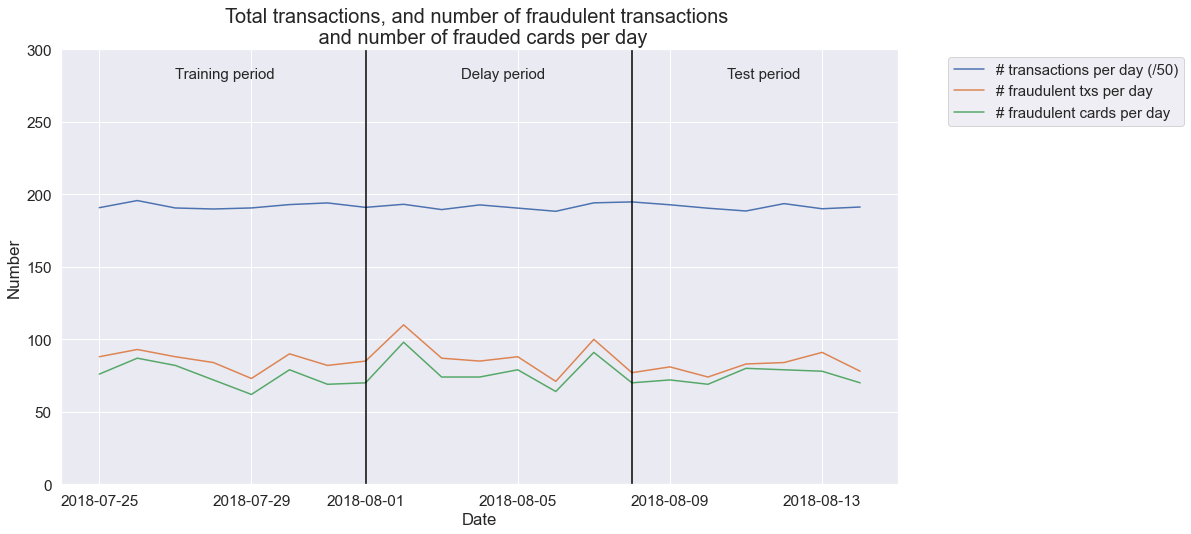

In [5]:
fraud_and_transactions_stats_fig

The plot shows us that the number of transactions and frauds is similar in the training and test periods. The average number of frauds is around 85 per day. Let us extract from the dataset the transactions for the training set and the test set. 

In [6]:
def get_train_test_set(transactions_df,start_date_training,end_date_training,start_date_test,end_date_test):
    
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<end_date_training+datetime.timedelta(days=1))]
    test_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_test) &
                               (transactions_df.TX_DATETIME<end_date_test+datetime.timedelta(days=1))]

    customer_frauded_train_df = list(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID.unique())
    
    test_df = test_df[~test_df.CUSTOMER_ID.isin(customer_frauded_train_df)]
    
    return (train_df, test_df)
                               

In [7]:
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,end_date_training,start_date_test,end_date_test)

The trainig set contains 67240 transactions, among which 598 are fradulent.

In [8]:
train_df.shape

(67240, 23)

In [9]:
train_df[train_df.TX_FRAUD==1].shape


(598, 23)

The test set contains 60285 transactions, among which 433 are fradulent.

In [10]:
test_df.shape

(60285, 23)

In [11]:
test_df[test_df.TX_FRAUD==1].shape


(433, 23)

## Model training 

The training of a prediction model consists in finding the mathematical relationship that exists between two sets of features, called *input* and *output* features. In a fraud detection context, the goal is to find a function that can predict whether a transaction is fraudulent or genuine (the output feature), using features that characterize the transactions (the input features).

We will define the input and output features as follows:

* The output feature will be the transaction label `TX_FRAUD`
* The input features will be the transaction amount `TX_AMOUNT`, as well as all the features that we computed in the previous section, which charaterize a transaction.


In [12]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


In Python, the training of a prediction model is made easy using the `sklearn` library. In particular, the  `sklearn`  library provide implementations for training a wide range of prediction models.  

The training and assessment of prediction models will be covereved in detail in later chapters. For now, we will simply aim at training and assessing some standard classifiers, without getting in the details of the training and assessment is actually performed.

We will rely on three different prediction models, called *decision tree*, *logistic linear regression*, and *random forest*. These models are often used in benchmarks in the fraud detection literature {cite}`yousefi2019comprehensive,10.1007/978-3-030-38501-9_29`. 
 


In [13]:
def fit_model_and_get_predictions(classifier, train_df, test_df, 
                                      input_features, output_feature="TX_FRAUD"):

    # We first train the classifier the `fit` method, and pass as arguments the input and output features
    classifier.fit(train_df[input_features], train_df[output_feature])
    
    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction 
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # The result is returned as a dictionary containing the fitted models, 
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier':classifier,
                                        'predictions_test':predictions_test,
                                        'predictions_train':predictions_train}
    
    return model_and_predictions_dictionary


Let us for example train a decision tree using the taining data.

In [14]:
# We first create a decision tree object. We will limit its depth to 2 for interpretability, 
# and set the random state to zero for reproducibility
classifier = DecisionTreeClassifier(max_depth = 2, random_state=0)

model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature)

Let us look at the predictions obtained for the first five transactions:

In [15]:
test_df['TX_FRAUD_PREDICTED']=model_and_predictions_dictionary['predictions_test']
test_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD_PREDICTED
1236698,1236698,2018-08-08 00:01:14,2765,2747,42.32,11145674,129,0,0,0,...,67.468529,120.0,64.611750,2.0,0.0,9.0,0.0,31.0,0.000000,0.003536
1236699,1236699,2018-08-08 00:02:33,714,2073,108.19,11145753,129,0,0,0,...,79.955455,124.0,85.365645,2.0,0.0,10.0,0.0,23.0,0.000000,0.003536
1236701,1236701,2018-08-08 00:08:40,4982,1258,26.13,11146120,129,0,0,0,...,56.269167,61.0,49.095902,1.0,0.0,10.0,0.0,26.0,0.076923,0.003536
1236702,1236702,2018-08-08 00:08:41,704,8501,65.81,11146121,129,0,0,0,...,62.643333,11.0,63.287273,1.0,0.0,6.0,0.0,23.0,0.000000,0.003536
1236703,1236703,2018-08-08 00:10:34,3085,4208,55.22,11146234,129,0,0,0,...,71.993846,72.0,59.899306,1.0,0.0,5.0,0.0,21.0,0.523810,0.003536


The probability of fraud for all these transactions is of 0.003536. We can display the decision tree to understand how these probabilities where set:

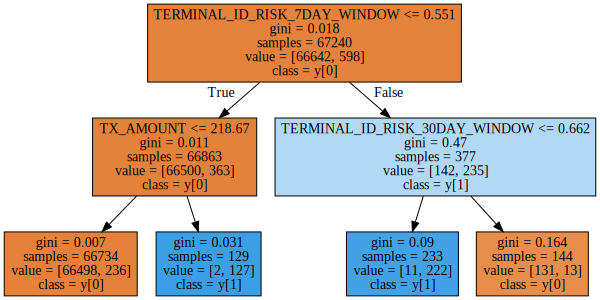

In [16]:
display(graphviz.Source(export_graphviz(classifier,feature_names=input_features,class_names=True, filled=True)))

A decision tree allows split the input space in different regions, in such a way that the fraudulent transactions are separated from the genuine transactions. The last level of the tree (the leaves) gives the number of fraudulent and genuine transactions in each of these regions. The color indicates whether a node or leaf of the tree contains a majority of genuine (orange) or fraudulent (blue) transactions.

Each of the five first transactions fall into the first leaf, a region that contains 460 fraudulent transactions and 66473 genuine transactions, that is, a region where the probability of fraud is $\frac{236}{66498+236}=0.003536$.

It is worth noting that the decision tree correctly found that all transactions whose amounts are higher than 220 are frauds (scenario 1 in the fraud generation process). The corresponding region is the fourth leaf, which contain 124 transactions, all fraudulent. 

## Accuracy assessment

In [17]:
def getPrecisionTopK(df_day,top_k):
    n_frauds=df_day.TX_FRAUD.sum()
    n_frauds_norm = top_k 
    nbr_correct_pred = df_day.head(top_k).TX_FRAUD.sum()
    pr_topn = nbr_correct_pred / n_frauds_norm
    return pr_topn


def get_percentage_detected_cards(predictions_df, top_k=100):
    
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    known_fraud_cards = []
    
    total_frauded_cards=len(predictions_df[predictions_df.TX_FRAUD==1].CUSTOMER_ID.unique())
    
    precision_top_k_per_day_list = []
    
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
        # and sorts by decreasing order of fraudulent prediction
        df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
        
        precision_top_k_per_day_list.append(getPrecisionTopK(df_day,top_k))
        
        df_top=df_day.head(top_k)
        
        known_fraud_cards = known_fraud_cards + list(df_top[df_top.TX_FRAUD==1].CUSTOMER_ID)
        predictions_df=predictions_df[~predictions_df.CUSTOMER_ID.isin(known_fraud_cards)]
    
    percentage_detected_cards=len(known_fraud_cards)/total_frauded_cards 
    
    #return np.array(precision_top_k_per_day_list).mean()#, len(known_fraud_cards)/total_frauded_cards 
    return percentage_detected_cards

def prediction_accuracy(predictions_df, output_feature='TX_FRAUD', prediction_feature='predictions', top_k=100):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    percentage_detected_cards = get_percentage_detected_cards(predictions_df, top_k)
    
    #Top_100= precision_top_k_per_day_list.mean()
    
    results = pd.DataFrame([[AUC_ROC, AP, percentage_detected_cards]], 
                           columns=['AUC ROC','Average precision',
                                    'Precision@'+str(top_k)])
    results = results.round(3)
    
    return results


Let us compute the accuracy in terms of AUC ROC, Average Precision (AP), and Precision Top 20.

In [18]:
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
    
prediction_accuracy(predictions_df, top_k=20)

,AUC ROC,Average precision,Precision@20
0,0.774,0.523,0.447


## Accuracy with other classifiers

We finally train three other predictions models using

* Linear regression
* Decision tree with unlimited depth
* Random forest

In [19]:
classifiers_dictionary={'Linear regression':LogisticRegression(), 
                        'Decision tree with depth of two':DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Decision tree - unlimited depth':DecisionTreeClassifier(random_state=0), 
                        'Random forest':RandomForestClassifier(random_state=0),
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:
    
    #start_time=time.time()
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df, 
                                                                                  input_features=input_features,
                                                                                output_feature=output_feature)
    #print(time.time()-start_time)
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions


In [20]:
def prediction_accuracy_model_collection(fitted_models_and_predictions_dictionary, transactions_df, type_set='test',top_k=100):

    results=pd.DataFrame(columns=['AUC ROC','Average precision',
                                  'Precision@'+str(top_k)])

    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        
        results_model=prediction_accuracy(predictions_df, output_feature='TX_FRAUD', 
                                          prediction_feature='predictions', top_k=top_k)
        results_model.index=[classifier_name]
        
        results=results.append(results_model)
        
    return results
    

In [21]:
# Accuracy on test set
df_results=prediction_accuracy_model_collection(fitted_models_and_predictions_dictionary, test_df, type_set='test', top_k=20)
df_results

,AUC ROC,Average precision,Precision@20
Linear regression,0.861,0.447,0.295
Decision tree with depth of two,0.774,0.523,0.447
Decision tree - unlimited depth,0.800,0.339,0.252
Random forest,0.878,0.684,0.457


In [22]:
# Accuracy on training set
df_results=prediction_accuracy_model_collection(fitted_models_and_predictions_dictionary, train_df, type_set='train', top_k=20)
df_results

,AUC ROC,Average precision,Precision@20
Linear regression,0.886,0.540,0.258
Decision tree with depth of two,0.802,0.586,0.340
Decision tree - unlimited depth,1.000,1.000,0.347
Random forest,1.000,1.000,0.347
